In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,accuracy_score
import pandas as pd
from sklearn.datasets import load_iris ##
import os
from sklearn.metrics import classification_report,accuracy_score
from sklearn import svm
from tqdm._tqdm_notebook import tqdm_notebook
import pandas as pd
import cv2

## Directory

In [3]:
base_dir = ("/Users/Hyunjee/Desktop/AMLS_19-20_SN16075203/B2")
os.chdir(base_dir)

dataset_dir = os.path.join(base_dir, 'img')
labels_filename = os.path.join(base_dir, 'labels.csv')



## Data Preparation

In [4]:

df = pd.read_csv(labels_filename)
df.columns=['original']
df["file_name"] = df['original'].str.split("\t").str[3]
df["eyecolour_label"] = df['original'].str.split("\t").str[1]
del df['original']
    
eye_colour = []
    
for eye in df.eyecolour_label:
    if eye == '0':
        eye_colour.append("Brown")
    elif eye == '1':
        eye_colour.append("Blue")
    elif eye == '2':
        eye_colour.append("Green")
    elif eye == '3':
        eye_colour.append("Gray")
    else:
        eye_colour.append("Black")
    
df['eye_colour'] = eye_colour
    

df

,file_name,eyecolour_label,eye_colour
0,0.png,1,Blue
1,1.png,2,Green
2,2.png,2,Green
3,3.png,2,Green
4,4.png,0,Brown
...,...,...,...
9995,9995.png,3,Gray
9996,9996.png,0,Brown
9997,9997.png,1,Blue
9998,9998.png,0,Brown


In [60]:
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras import models
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from sklearn.model_selection import train_test_split
from keras.optimizers import adam
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [61]:

train_data, test_data = train_test_split(df, random_state=0)
    
# Setup the data generator
data_generator = ImageDataGenerator(
    rescale = 1./255.,
    validation_split = 0.25,
    horizontal_flip=True,
    vertical_flip=True
    
)
    
# Get batches of training dataset from the dataframe
print("Training Dataset Preparataion")
train_generator = data_generator.flow_from_dataframe(
        dataframe = train_data, directory = dataset_dir,
        x_col = "file_name", y_col = "eyecolour_label",
        class_mode = 'categorical', target_size = (30,30),
        batch_size = 32, subset = 'training')
    
    # Get batches of validation dataset from the dataframe
print("\nValidation Dataset Preparataion")
validation_generator = data_generator.flow_from_dataframe(
        dataframe = train_data, directory = dataset_dir,
        x_col = "file_name", y_col = "eyecolour_label",
        class_mode = 'categorical', target_size = (30,30),
        batch_size = 32, subset = 'validation')
    
    
    

Training Dataset Preparataion
Found 5625 validated image filenames belonging to 5 classes.

Validation Dataset Preparataion
Found 1875 validated image filenames belonging to 5 classes.


In [62]:
# starting point 
model= models.Sequential()

# Add first convolutional block
model.add(Conv2D(24, (3, 3), activation='relu', padding='same',input_shape=(30,30,3)))
model.add(MaxPooling2D((2, 2), padding='same'))

# second block
model.add(Conv2D(24, (3, 3), activation='relu', padding='same'))
#model.add(MaxPooling2D((2, 2), padding='same'))
# third block
model.add(Conv2D(48, (3, 3), activation='relu', padding='same'))
#model.add(MaxPooling2D((2, 2), padding='same'))
# fourth block
model.add(Conv2D(96, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

# global average pooling
#model.add(GlobalAveragePooling2D())
# fully connected layer
#model.add(Dense(64, activation='relu'))
#model.add(BatchNormalization())
# make predictions
model.add(Flatten())
model.add(Dense(5, activation='softmax'))




# Show a summary of the model. Check the number of trainable parameters
model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 24)        672       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 24)        5208      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 48)        10416     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 96)        41568     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 96)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6144)             

In [63]:
# use early stopping to optimally terminate training through callbacks
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# save best model automatically
mc= ModelCheckpoint('/Users/Hyunjee/Desktop/AMLS_19-20_SN16075203/B1/model_B1.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

cb_list=[es,mc]


# compile model 
optimizer = optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])



In [64]:
history = model.fit_generator(
        train_generator,
        epochs=25,
        steps_per_epoch=train_generator.samples // 32,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // 32,
        callbacks=cb_list)

Epoch 1/25
175/175 [==============================] - 70s 399ms/step - loss: 1.6105 - accuracy: 0.1954 - val_loss: 1.6109 - val_accuracy: 0.1923

Epoch 00001: val_loss improved from inf to 1.61089, saving model to /Users/Hyunjee/Desktop/AMLS_19-20_SN16075203/B1/model_B1.h5
Epoch 2/25
175/175 [==============================] - 72s 414ms/step - loss: 1.6097 - accuracy: 0.1995 - val_loss: 1.6087 - val_accuracy: 0.1877

Epoch 00002: val_loss improved from 1.61089 to 1.60867, saving model to /Users/Hyunjee/Desktop/AMLS_19-20_SN16075203/B1/model_B1.h5
Epoch 3/25
175/175 [==============================] - 71s 407ms/step - loss: 1.6096 - accuracy: 0.1986 - val_loss: 1.6085 - val_accuracy: 0.1926

Epoch 00003: val_loss improved from 1.60867 to 1.60851, saving model to /Users/Hyunjee/Desktop/AMLS_19-20_SN16075203/B1/model_B1.h5
Epoch 4/25
175/175 [==============================] - 67s 382ms/step - loss: 1.6096 - accuracy: 0.1958 - val_loss: 1.6092 - val_accuracy: 0.1948

Epoch 00004: val_loss di

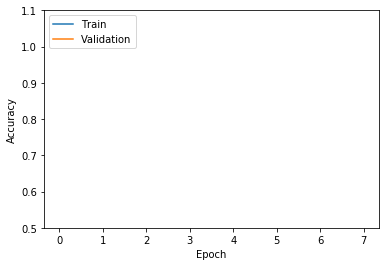

In [65]:
# plot training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([.5,1.1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("model_gender.png", dpi=300)